In [ ]:
''' Import numpy, pandas, sklearn modules and libraries'''
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA 
from lightgbm import LGBMClassifier
# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
from functools import reduce
from sklearn.preprocessing import LabelEncoder
# Keras Librry
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
def train_application():
    """
    This function reads application_train.csv and application_test.csv
    files, cleans them and perform manual feature engineering for each
    application (SK_ID_CURR).   
    
    Parameters:
    None

    Returns:
    train: train dataFrame which includes hand engineered features from 
                  just application_train table.   
    
    """

    print('Processing application_train and application_test tables')
    train = pd.read_csv('application_train.csv')
    # Delete four applications with XNA CODE_GENDER (train set)
    train = train[train['CODE_GENDER'] != 'XNA']
    # Replace DAYS_EMPLOYED = 365243 by nan
    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) 
    # Feature engineering
    train['Days_employed_age']   = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
    train['Credit_income_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
    train['Anuity_income_ratio'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] 
    train['Income_per_person']   = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
    #length of the payment in months since the annuity is the monthly amount due
    train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] 
    return train

def bureau_journey():
    """
    This function reads bureau.csv and burea_balance.csv tables which includes the recorded
    ID of previous credit bureau (SK_ID_BUREAU), hand engineered new features, and 
    returns the statiscs related to each application SK_ID_CURR.

    Parameters:
    None

    Returns:
    stats: pandas DataFrame including bureau related statistics for each SK_ID_CURR.  
    """

    print('Processing bureau and bureau balance tables...')
    bureau = pd.read_csv('bureau.csv')
    # ------------------------------------Feature Engineering (1): General ------------------------------------------
    bureau['Days_early_paidoff'] =  bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['Duration_real']      = bureau['DAYS_ENDDATE_FACT'] - bureau['DAYS_CREDIT']
    bureau['Duration_planned']   = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT'] 
    #Replace data with Duration_planned = 0 with 1 to avoide devision by zero
    bureau['Duration_planned'].replace({0: 1}, inplace = True) 
    # Weighted sum of credit a person borrowed (per days) 
    bureau['AMT_weightdebt_duration'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['Duration_planned']
    # 'AMT_CREDIT_SUM_OVERDUE': Current amount overdue on credit 
    bureau['AMT_Overdue_duration'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / bureau['Duration_planned'] 
    # Maximal amount overdue so far 
    bureau['AMT_Maxoverdue_duration'] = bureau['AMT_CREDIT_MAX_OVERDUE']/bureau['Duration_planned'] 
    # Defaulted: CREDIT_DAY_OVERDUE > 270 days is considered defaluted
    bureau['Defaulted'] = np.where(bureau['CREDIT_DAY_OVERDUE'] > 270, 1, 0)
    bureau['AMT_defaulted'] = bureau['Defaulted']*bureau['AMT_CREDIT_SUM_DEBT']
    # Encoding CREDIT_ACTIVE ('Closed','Active') to (0,1)
    mapping = {'Closed':0, 'Active': 1}
    bureau['CREDIT_ACTIVE'] = bureau['CREDIT_ACTIVE'].map(mapping)
    # Flatten manual features with aggregations 
    stats = bureau.sort_values('DAYS_CREDIT', ascending = False).groupby('SK_ID_CURR') \
          .agg({'AMT_CREDIT_SUM_DEBT': ['count' ,'sum', 'mean'], 
                'AMT_weightdebt_duration': ['sum', 'mean'], 
                'AMT_Overdue_duration': [ 'sum', 'mean'], 
                'AMT_Maxoverdue_duration': ['mean'], 
                'Days_early_paidoff': [ 'sum', 'mean'],
                'Defaulted':[ 'sum', 'mean'], 
                'AMT_defaulted':[ 'sum', 'mean'],
                'CREDIT_ACTIVE': 'sum'}) 
    stats.columns = stats.columns.map('_'.join)
    # Flatten last four stats for each applicant (nth() method does not work with .agg method)
    columns = ['SK_ID_CURR', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'AMT_weightdebt_duration', 'AMT_Overdue_duration', \
              'Days_early_paidoff','Defaulted', 'AMT_defaulted'] 
    stats0  = bureau.sort_values('DAYS_CREDIT', ascending = False)[columns].groupby('SK_ID_CURR').nth(0) 
    stats1  = bureau.sort_values('DAYS_CREDIT', ascending = False)[columns].groupby('SK_ID_CURR').nth(1)
    stats2  = bureau.sort_values('DAYS_CREDIT', ascending = False)[columns].groupby('SK_ID_CURR').nth(2)
    stats3  = bureau.sort_values('DAYS_CREDIT', ascending = False)[columns].groupby('SK_ID_CURR').nth(3)
    data_frames = [stats0, stats1, stats2, stats3]
    lags = reduce(lambda  left,right: pd.concat( [left,right], axis=1, sort= False), data_frames)
    col=[]
    for i in range(4):
        col += ['DAYS_CREDIT'+str(i), 'AMT_CREDIT_SUM_DEBT'+ str(i), 'AMT_weightdebt_duration'+ str(i), \
                'AMT_Overdue_duration'+ str(i), 'Days_early_paidoff'+ str(i),'Defaulted'+ str(i), 'AMT_defaulted'+ str(i)] 
    lags.columns = col  
    stats = pd.merge(stats, lags, on= 'SK_ID_CURR', how ='outer')
    #--------------------------- Feature Engineering (2): Loan cycle life for different CREDIT_TYPE------------------------------
    # Select 6 categories of loans with the highest frequency 
    filter = (bureau['CREDIT_TYPE'] == 'Mortgage')  | (bureau['CREDIT_TYPE'] == 'Real estate loan') \
              | (bureau['CREDIT_TYPE'] == 'Car loan') \
              | (bureau['CREDIT_TYPE'] == 'Loan for business development') \
              | (bureau['CREDIT_TYPE'] == 'Loan for the purchase of equipment') \
              | (bureau['CREDIT_TYPE'] == 'Cash loan (non-earmarked)')\
              | (bureau['CREDIT_TYPE'] == 'Loan for working capital replenishment')  
    btype = bureau[filter].copy()
    # first(DAYS_CREDIT) is when the last credit of each credit type applied and last(DAYS_CREDIT) is when the first onces applied.
    bt_stats  = btype.sort_values('DAYS_CREDIT', ascending = False).groupby(['SK_ID_CURR','CREDIT_TYPE'])\
               .agg({ 'DAYS_CREDIT': ['first', 'last'], 'AMT_CREDIT_SUM_DEBT': ['count', 'sum', 'mean'],\
                      'CREDIT_ACTIVE': 'sum' ,'Defaulted':'sum', 'AMT_defaulted':['sum']})
    bt_stats.columns = bt_stats.columns.map('_'.join)
    mortgage = bt_stats[bt_stats.index.isin(['Mortgage'], level='CREDIT_TYPE')]
    mortgage.index = mortgage.index.droplevel('CREDIT_TYPE')
    realestate = bt_stats[bt_stats.index.isin(['Real estate loan'], level='CREDIT_TYPE')]
    realestate.index = realestate.index.droplevel('CREDIT_TYPE')
    carloan = bt_stats[bt_stats.index.isin(['Car loan'], level='CREDIT_TYPE')]
    carloan.index = carloan.index.droplevel('CREDIT_TYPE')
    loanbusiness = bt_stats[bt_stats.index.isin(['Loan for business development'], level='CREDIT_TYPE')]
    loanbusiness.index = loanbusiness.index.droplevel('CREDIT_TYPE')
    loanpurchase = bt_stats[bt_stats.index.isin(['Loan for the purchase of equipment'], level='CREDIT_TYPE')]
    loanpurchase.index = loanpurchase.index.droplevel('CREDIT_TYPE')
    cashloan = bt_stats[bt_stats.index.isin(['Cash loan (non-earmarked)'], level='CREDIT_TYPE')]
    cashloan.index = cashloan.index.droplevel('CREDIT_TYPE')
    workingloan = bt_stats[bt_stats.index.isin(['Loan for working capital replenishment'], level='CREDIT_TYPE')]
    workingloan.index = workingloan.index.droplevel('CREDIT_TYPE')
    dataframes = [mortgage, realestate, carloan, loanbusiness, loanpurchase, cashloan, workingloan]
    credit_type = reduce(lambda left, right: pd.merge(left,right, on = 'SK_ID_CURR', how= 'outer'), dataframes)
    types = ['mortgage', 'realestate', 'carloan', 'loanbusiness', 'loanpurchase', 'cashloan', 'workingloan']
    columns =[]
    for s in types:
        columns += ['DAYS_CREDIT_first_' + s,  'DAYS_CREDIT_last_' + s , 'AMT_CREDIT_SUM_DEBT_count_'+ s,   \
                    'AMT_CREDIT_SUM_DEBT_sum_' + s , 'AMT_CREDIT_SUM_DEBT_mean_' + s ,   \
                    'CREDIT_ACTIVE_sum_x_' + s , 'Defaulted_sum_x_' + s , 'AMT_defaulted_sum_' + s]
    credit_type.columns = columns
    stats.merge(credit_type, on ='SK_ID_CURR', how= 'outer')
    #-----------------------------Feature Engineering (3): Loan cycle life for Credit Card----------------------------------------
    ccdebt_bureau = bureau[bureau['CREDIT_TYPE'] == 'Credit card'].sort_values('DAYS_CREDIT', ascending = False)\
                          .groupby('SK_ID_CURR').agg({'AMT_CREDIT_SUM_DEBT':['count','sum', 'mean', 'first']})
    ccdebt_bureau.columns = ccdebt_bureau.columns.map('_'.join)
    stats = stats.merge(ccdebt_bureau, on= 'SK_ID_CURR', how = 'outer')
    #------------------------------Feature Engineering (4): Bureau Balance Table---------------------------------------------------
    bureaubal = pd.read_csv('bureau_balance.csv')
    # When did the credit closed? When was the last delinquency for each bureau credit?
    # Last close is obtained by first 0 in MONTHS_BALANCE, last delinquency is obtained from first 1.
    bbalance = bureaubal.groupby(['SK_ID_BUREAU','STATUS'], as_index=False).first()
    left  = bbalance[(bbalance['STATUS'] == '0')][['SK_ID_BUREAU','MONTHS_BALANCE']]
    right = bbalance[(bbalance['STATUS'] == '1')][['SK_ID_BUREAU','MONTHS_BALANCE']]
    bbalance = pd.merge(left,right, on= 'SK_ID_BUREAU', how='left')
    bbalance.columns = ['SK_ID_BUREAU','Months_latest_open','Months_latest_delin']
    # Delinquency ratios: how often each bureau delayed? 
    delinquency = pd.get_dummies(bureaubal[(bureaubal['STATUS'] != 'X') & (bureaubal['STATUS'] != 'C')])
    delinquency = delinquency.groupby('SK_ID_BUREAU').agg({'STATUS_0':'mean','STATUS_1':'mean','STATUS_2':'mean','STATUS_3':'mean',
                                                     'STATUS_4':'mean','STATUS_5':'mean'}) 
    bbalance = bbalance.merge(delinquency, on='SK_ID_BUREAU', how = 'inner')
    # Add SK_ID_CURR to bbalance dataframe
    bbalance = bureau[['SK_ID_CURR','SK_ID_BUREAU']].merge(bbalance, on = 'SK_ID_BUREAU', how= 'inner')
    # pick the latest open SK_ID_Bureau 
    bbalance = bbalance.sort_values('Months_latest_open', ascending= False).groupby('SK_ID_CURR').first()
    # merge with stats
    stats = stats.merge(bbalance, on ='SK_ID_CURR', how='outer')
    return stats

def homecredit_prv_app():
    """
    This function reads previous_application.csv which includes the recorded
    ID of previous credit at Home Credit company (SK_ID_PREV), hand engineered new features, and 
    returns the statiscs related to each application SK_ID_CURR.

    Parameters:
    None

    Returns:
    prev1: pandas DataFrame having statistics related to previous loans for each SK_ID_CURR at Home Credit.  
    """

    print('Processing previous application tables at Home Credit....')
    prev = pd.read_csv('previous_application.csv')
    #------------------------------Feature Engineering (1): General ---------------------------
    # When was the last application applied and contract status?
    prev1 = prev.sort_values('DAYS_DECISION', ascending = False).\
                 groupby(['SK_ID_CURR']).agg({'DAYS_DECISION':'first', 'NAME_CONTRACT_STATUS': 'first', 'AMT_CREDIT' : 'first'})
    # last credit amount, interest rates, ... the most recent approved 
    df = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved'] \
                  .sort_values('DAYS_DECISION', ascending = False).groupby('SK_ID_CURR').first()
    df = df[['NAME_CONTRACT_TYPE', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
                  'NAME_YIELD_GROUP','NFLAG_INSURED_ON_APPROVAL','RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']]
    df['Diff_applied_apprved'] = df['AMT_APPLICATION'] - df['AMT_CREDIT']
    prev1 = prev1.merge(df , on='SK_ID_CURR', how= 'outer')
    #--------------------Feature Engineering (2): Ratioss of Approved Refused Canceled and Unused offer for each application-----------
    df = prev.groupby(['SK_ID_CURR','NAME_CONTRACT_STATUS']).agg({'SK_ID_PREV':'count'})
    df = df.groupby(level='SK_ID_CURR').apply(lambda x: x/x.sum())
    approved = df[df.index.isin(['Approved'], level='NAME_CONTRACT_STATUS')]['SK_ID_PREV']
    approved.index = approved.index.droplevel('NAME_CONTRACT_STATUS')
    refused  = df[df.index.isin(['Refused'], level='NAME_CONTRACT_STATUS')]['SK_ID_PREV']
    refused.index = refused.index.droplevel('NAME_CONTRACT_STATUS')
    canceled = df[df.index.isin(['Canceled'], level='NAME_CONTRACT_STATUS')]['SK_ID_PREV']
    canceled.index = canceled.index.droplevel('NAME_CONTRACT_STATUS')
    unused   = df[df.index.isin(['Unused offer'], level='NAME_CONTRACT_STATUS')]['SK_ID_PREV']
    unused.index = unused.index.droplevel('NAME_CONTRACT_STATUS')
    data_frames = [approved,refused,canceled,unused]
    df = reduce(lambda  left,right: pd.merge( left,right, on = 'SK_ID_CURR', how='outer'), data_frames)
    df.columns = ['ratio_approved','ratio_refused','ratio_canceled', 'ratio_unused']
    prev1 = prev1.merge(df, on='SK_ID_CURR', how= 'outer')
    #--------------------Feature Engineering (3): Latest credit time and amount for the approved different NAME_CONTRACT_TYPE -------------
    df = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved'].sort_values('DAYS_DECISION', ascending = False).\
                 groupby(['SK_ID_CURR','NAME_CONTRACT_TYPE']).agg({'DAYS_DECISION':'first', 'AMT_CREDIT' : 'first'})
    consumer_loans = df[df.index.isin(['Consumer loans'], level='NAME_CONTRACT_TYPE')][['DAYS_DECISION','AMT_CREDIT']]
    consumer_loans.index = consumer_loans.index.droplevel('NAME_CONTRACT_TYPE')
    cash_loans = df[df.index.isin(['Cash loans'], level='NAME_CONTRACT_TYPE')][['DAYS_DECISION','AMT_CREDIT']]
    cash_loans.index = cash_loans.index.droplevel('NAME_CONTRACT_TYPE')
    revolving_loans = df[df.index.isin(['Revolving loans'], level='NAME_CONTRACT_TYPE')][['DAYS_DECISION','AMT_CREDIT']]
    revolving_loans.index = revolving_loans.index.droplevel('NAME_CONTRACT_TYPE')
    dfs = [consumer_loans,cash_loans, revolving_loans]
    df = reduce(lambda left,right: pd.merge(left,right, on ='SK_ID_CURR', how = 'outer'), dfs )
    df.columns = ['Days_consumerloans', 'AMT_credit_consumerloans', 'Days_cashloans','AMT_credit_cashloans',
                        'Days_revolvingloans','AMT_credit_revolvingloans']
    prev1 = prev1.merge(df, on='SK_ID_CURR', how= 'outer') 
    return prev1

def homecredit_cc():
    """
    This function reads credit_card_balance.csv having recorded
    ID of previous credit card at Home Credit company (SK_ID_PREV), 
    hand engineered new features, and returns the statiscs related to each application SK_ID_CURR.

    Parameters:
    None

    Returns:
    stats: pandas DataFrame having statistics related to previous credit card for each SK_ID_CURR at Home Credit.  
    """

    ccb = pd.read_csv('credit_card_balance.csv')
    ccb['Beyond_limit'] = np.where(ccb['AMT_BALANCE'] > ccb['AMT_CREDIT_LIMIT_ACTUAL'] , 1, 0)
    ccb['Delinquent'] = np.where(ccb['AMT_PAYMENT_CURRENT'] < ccb['AMT_INST_MIN_REGULARITY'] , 1, 0)
    # Percentage change of credit card balance between two successive months
    def pct_diff(group):
      group['balance_pct_change'] = group['AMT_BALANCE'].diff()/(group['AMT_BALANCE'].shift(1)+1)
      group['balance_pct_change'] = np.where(group['balance_pct_change'] > 30, 30, group['balance_pct_change'])
      return group
    ccb = ccb.sort_values('MONTHS_BALANCE').groupby('SK_ID_PREV').apply(pct_diff)    
    # how many times credit card reached 80% and above?
    ccb['times_bal80'] = np.where(ccb['AMT_BALANCE']/ccb['AMT_CREDIT_LIMIT_ACTUAL'] >= 0.8, 1, 0)
    # How many credit card do applicant have at the moment? What is the total balance on them? (outstanding debt of credit card)
    ccb['has_cc_now'] = np.where(ccb['MONTHS_BALANCE'] == -1 , 1 , 0 )
    ccb['balance_now'] = ccb['has_cc_now'] * ccb['AMT_BALANCE'] 
    stats = ccb.groupby('SK_ID_CURR', as_index=False).agg({'has_cc_now': 'sum', 'balance_now': 'sum', 'times_bal80': 'sum'})
    # Flatten last four months balance and percentage change for each applicant
    cols = ['MONTHS_BALANCE','Beyond_limit','Delinquent','balance_pct_change']
    cclast = ccb.sort_values('MONTHS_BALANCE', ascending = False).groupby(['SK_ID_CURR'])[cols].nth(0)
    cclag1 = ccb.sort_values('MONTHS_BALANCE', ascending = False).groupby(['SK_ID_CURR'])[cols].nth(1)
    cclag2 = ccb.sort_values('MONTHS_BALANCE', ascending = False).groupby(['SK_ID_CURR'])[cols].nth(2)
    cclag3 = ccb.sort_values('MONTHS_BALANCE', ascending = False).groupby(['SK_ID_CURR'])[cols].nth(3)
    dfs = [cclast, cclag1, cclag2, cclag3]
    lags = reduce(lambda left,right: pd.concat([left,right], axis=1, sort= False), dfs)
    columns = []
    for i in range(4):
        columns += ['MONTHS_BALANCE'+str(i), 'Beyond_limit'+str(i),'Delinquent'+str(i), 'balance_pct_change'+str(i)]
    lags.columns = columns
    stats = stats.merge(lags, on='SK_ID_CURR', how= 'outer')
    return stats

def installment():
    """
    This function reads installments_payments.csv having recorded
    ID of previous installment payment at Home Credit company (SK_ID_PREV), 
    hand engineered new features, and returns the statiscs related to each application SK_ID_CURR.

    Parameters:
    None

    Returns:
    stats: pandas DataFrame having statistics related to previous installment for each SK_ID_CURR at Home Credit.
    """

    insta = pd.read_csv('installments_payments.csv')
    # 'DAYS_INSTALMENT': days before credit card supposed to be paid, 'DAYS_ENTRY_PAYMENT': days that amount was acutually paid
    insta['insta_delinquency'] = np.where(insta['DAYS_INSTALMENT'] >= insta['DAYS_ENTRY_PAYMENT'], 0, 1)
    insta['insta_debt'] = insta['AMT_INSTALMENT'] - insta['AMT_PAYMENT']
    stats = insta.sort_values('DAYS_INSTALMENT', ascending = False).groupby(['SK_ID_CURR']).agg({'DAYS_INSTALMENT':'first','insta_debt': ['sum', 'mean', 'first'], 'insta_delinquency' :['sum','first']})
    stats.columns = stats.columns.map('_'.join)
    return stats

def pos_cash():
    """
    This function reads POS_CASH_balance.csv having recorded
    ID of previous point of sale (POS) transaction for each Home Credit company credit (SK_ID_PREV), 
    hand engineered new features, and returns the statiscs related to each application SK_ID_CURR.

    Parameters:
    None

    Returns:
    poslag: pandas DataFrame having statistics related to previous POS for each SK_ID_CURR at Home Credit.
    """

    pc = pd.read_csv('POS_CASH_balance.csv')
    # Flatten all the columns for the latest 4 POS data for each application 
    pc = pc.sort_values('MONTHS_BALANCE', ascending = False)
    cols = ['MONTHS_BALANCE','SK_DPD','SK_DPD_DEF']
    pos0 = pc.groupby(['SK_ID_CURR'])[cols].first()
    pos1 = pc.groupby(['SK_ID_CURR'])[cols].nth(1)
    pos2 = pc.groupby(['SK_ID_CURR'])[cols].nth(2)
    pos3 = pc.groupby(['SK_ID_CURR'])[cols].nth(3)
    data_frames = [pos0, pos1, pos2, pos3]
    poslag = reduce(lambda  left,right: pd.concat( [left,right], axis=1, sort= False), data_frames)
    columns =[]
    for i in range(4):
        columns += ['MONTHS_BALANCE' + str(i), 'SK_DPD'+ str(i),'SK_DPD_DEF'+ str(i) ]
    poslag.columns = columns
    return poslag

def merge_tables():
    ''' 
    This function merges the hand-engineered features obtained from bureau and home credit company with
    the main application for training and test datasets

    Parameters:
    None

    Returns:
    train: train DataFrame which includes hand engineered features from 
                  all tables including main application, bureau, and previous Home Credit tables.  

    '''

    prev_home   = homecredit_prv_app()
    prev_home   = prev_home.merge(homecredit_cc(), on='SK_ID_CURR', how= 'outer')
    prev_home   = prev_home.merge(installment(), on='SK_ID_CURR', how= 'outer')
    prev_home   = prev_home.merge(pos_cash(), on='SK_ID_CURR', how= 'outer')
    train       = train_application()
    train       = train.merge(bureau_journey(), on='SK_ID_CURR', how='left')
    train       = train.merge(prev_home, on='SK_ID_CURR', how='left')
    print('All tables succesfully merged...')
    return train

def preprocessing(train):
    '''
    This function calculates the correlation between all features in training data and drops the columns with 
    correlation > 0.98. Then, it encodes categorical features and save them as 'category' type for lightGBM algorithms.

    Parameters:
    train: trainig dataset after merging all the tables.

    Returns:
    train:  train DataFrame which includes preprocessed training dataset.
    '''

    print('Preprocessing final table, imputing missing values, and One-hot encoding of categorical features...')
    # Drop the columns with correlation > 0.98
    corr = train.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    train = train.drop(to_drop, axis=1)
    
    # Imputating the missing data in bureau table
    # Missing categorical features are imputed with 'Not_applicable'
    # Missing numeric features are imputed with Zero (logical choice for this dataset)
    cols = train.select_dtypes(include = object).columns
    train[cols] = train[cols].fillna('Not_Applicable')
    cols = train.select_dtypes(exclude = object).columns
    train[cols] = train[cols].fillna(0)

    # One-hot encoding of categorical features
    train = pd.get_dummies(train, drop_first=True)

    return train

In [ ]:
def calculate_metrics(pred_class, pred, y_test):
    '''
    This function calculates the classificaiton metrics including precision, recall, F1-Score, AUC_ROC, and cohen-kappa coefficient.

    Parameters:
    pred_class: Binary class prediction of the target variable.
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''

    # ROC_AUC score
    print('ROC_AUC of the test set:', roc_auc_score(y_test, pred))
    # Precision/Recall (0.1 Threshold)
    pred_class_2 = (np.array(pred) > 0.1).astype(int)
    cm = confusion_matrix(y_test, pred_class_2)
    print('\nConfusion_metrix (0.1 Threshold): \n', cm)
    # True Negatives (TN)
    tn = cm[0][0]
    # False Positives (FP)
    fp = cm[0][1]    
    # False Negatives (FN)
    fn = cm[1][0]
    # True Positives (TP)
    tp = cm[1][1]
    precision = tp / (tp + fp)
    print( 'Precision (0.1 Threshold): ', precision )
    recall = tp / (tp + fn)
    print( 'Recall (0.1 Threshold): ', recall )
    print( 'F1-score ( 0.1 Threshold):', 2*precision*recall/(precision+recall))
    cohen_kappa = cohen_kappa_score(y_test, pred_class_2)
    print( '\nCohen_kappa (0.1 Threshold): ', cohen_kappa )

def plot_ROC(y_test, pred):
    '''
    This function plots ROC based on y_test and predictied probability of positive class by lightGBM.

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''

    # Initialize figure
    fig = plt.figure(figsize=(9,9))
    plt.title('Receiver Operating Characteristic')
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr)
    # Diagonal 45 degree line
    plt.plot([0,1],[0,1],'k--')
    # Axes limits and labels
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_precision_recall(y_test, pred):
    '''
    This function plots precicision_recall curve based on y_test and predictied probability of positive class by lightGBM..

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset
    
    Returns:
    None
    '''

    precision, recall, thresholds = precision_recall_curve(y_test, pred)
    fig = plt.figure(figsize=(9,9))
    plt.title('Precision_Recall')
    # Plot Precision-Recall curve
    plt.plot(recall, precision)
    # Axes limits and labels
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

In [ ]:
def FCNN(train, test_size):

    train = train[:40000]
    print('Applying Fully Connected Neural Network (FCNN) ...')
    y = train['TARGET']
    X = train.drop('TARGET', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = test_size, random_state=1234)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    # Deep FCNN implementation
    # FCNN architecture includes 3 fully connected units having 150, 75, 25 neurons, respectively.
    batch_size = 256
    epochs = 10
    np.random.seed(5)        

    #FC1
    model = Sequential()
    model.add(Dense(input_shape= (X_train.shape[1],), units = 150))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    #FC2
    model.add(Dense(units = 75))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    #FC3
    model.add(Dense(units = 25))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    #Output layer
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    model.build()
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['AUC'])
    model.summary()

    # Train deep neural network
    early_stops = EarlyStopping(patience=10, monitor='val_auc')
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=0, save_best_only=True)
    model.fit(X_train, y_train, validation_split=0.05, callbacks=[early_stops, mc], batch_size= batch_size, epochs= epochs, verbose=1)

    # Binary class prediction, Keras predict method always return probability (unlike Sklearn!)
    pred_class = np.argmax(model.predict(X_test), axis=-1)
    # Probability prediction
    pred = model.predict(X_test)

    return pred_class, pred, y_test

Applying Fully Connected Neural Network (FCNN) ...
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 150)               51450     
_________________________________________________________________
batch_normalization_60 (Batc (None, 150)               600       
_________________________________________________________________
activation_60 (Activation)   (None, 150)               0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 75)                11325     
_________________________________________________________________
batch_normalization_61 (Batc (None, 75)                300       
_________________________________________________________________
ac

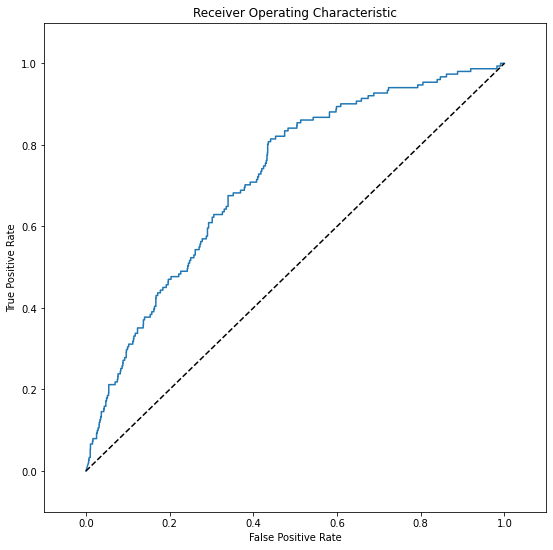

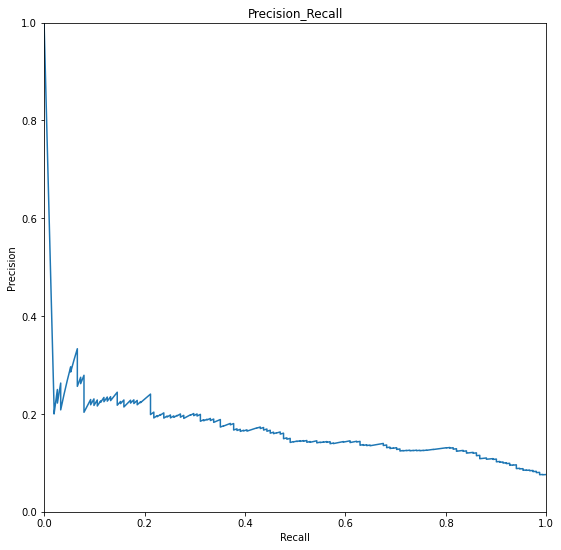

In [ ]:
''' -------------------------------Main---------------------------
The main calls all funcitons sequentillay, merge the tables, train Fully Connected Neural Network (FCNN), and plot the classification metrics.
'''

# Cleaning, feature engineering, and flattening of data from bureau and HomeCredit 
# and merging the application_train 
train = merge_tables()
# Preprocesing including imputing missing values, one-hot encoding of categorical varibles for FCNN 
train = preprocessing(train)
# Training FCNN
test_size = 0.05 # ratio of test to train size
pred_class, pred, y_test = FCNN(train, test_size)
# Evalutate ROC_AUC, Precision, Recall, F1-Score, Kohen-Cappa metrics
calculate_metrics(pred_class, pred, y_test)
# Plot ROC curve
plot_ROC(y_test, pred)
# Plot Precision/R curve
plot_precision_recall(y_test, pred)